In [ ]:
from os import path
import json
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

base = "/content/drive/MyDrive/NLP100/ch09"

fp_train = "80/train.csv"
fp_valid = "80/valid.csv"
fp_words = "80/word_ids.json"
df_train = pd.read_csv(path.join(base, fp_train), index_col=0)
df_valid = pd.read_csv(path.join(base, fp_valid), index_col=0)
word_ids = json.load(open(path.join(base, fp_words), "r"))
df_train.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,0,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,2,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,0,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,2,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-06-1...,Businessweek,0,dXVU3KhKpHSxleMNmc46pQj6e5zwM,www.businessweek.com,1403113194649


In [ ]:
num_words_of_title = max([len(title.split()) for title in df_train["TITLE"]])


def title_to_ids(t):
  res = [0 for _ in range(num_words_of_title)]
  for i, w in enumerate(t.split()):
    if w in word_ids.keys():
      res[i] = word_ids[w]
  return res


title_to_ids("Europe reaches crunch point on banking union")[:5]

[252, 2031, 0, 1500, 4]

In [ ]:
X_train = torch.tensor([title_to_ids(title) for title in df_train["TITLE"]])
y_train = torch.tensor(df_train["CATEGORY"].values.astype("int"))
X_valid = torch.tensor([title_to_ids(title) for title in df_valid["TITLE"]])
y_valid = torch.tensor(df_valid["CATEGORY"].values.astype("int"))
print(X_train[:5])

tensor([[ 599, 3939,    0,  ...,    0,    0,    0],
        [6646,  515,    1,  ...,    0,    0,    0],
        [   7,    0, 6648,  ...,    0,    0,    0],
        [ 326,  419,    6,  ...,    0,    0,    0],
        [1521, 1382, 2762,  ...,    0,    0,    0]])


In [ ]:
batch_size = 16
num_workers = 2
dataset_train = [(X_i, y_i) for X_i, y_i in zip(X_train, y_train)]
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataset_valid = [(X_i, y_i) for X_i, y_i in zip(X_valid, y_valid)]
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
num_embeddings = max(word_ids.values()) + 1
embedding_dim = 300
hidden_size = 50
bidirectional = True
num_layers = 2


class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, bidirectional=bidirectional, num_layers=num_layers)
    if bidirectional:
      self.linear = nn.Linear(hidden_size * 2, 4)
    else:
      self.linear = nn.Linear(hidden_size, 4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    if bidirectional:
      hidden = torch.zeros(num_layers * 2, x.size(0), hidden_size).to(device)
    else:
      hidden = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
    y = self.embedding(x)
    y, hidden = self.rnn(y, hidden)
    y = self.linear(y[:, -1, :])
    y = self.softmax(y)
    return y

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"device: {device}")
model = Model().to(device)
print(model)

device: cuda
Model(
  (embedding): Embedding(10272, 300, padding_idx=0)
  (rnn): RNN(300, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.95)

loss_train = []
correct_train = []
loss_valid = []
correct_valid = []

for epoch in range(10):
  print(f"Epoch {epoch + 1}\n-------------------------------")
  size = len(dataloader_train.dataset)
  for batch, (X, y) in enumerate(dataloader_train):
    X, y = X.to(device), y.to(device)
    loss = loss_fn(model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 1000 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  scheduler.step()

  size = len(dataloader_train.dataset)
  loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader_train:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  loss /= size
  correct /= size
  loss_train.append(loss)
  correct_train.append(correct)

  size = len(dataloader_valid.dataset)
  loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader_valid:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  loss /= size
  correct /= size
  loss_valid.append(loss)
  correct_valid.append(correct)
  print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {loss:>8f} \n")

Epoch 1
-------------------------------
loss: 1.389102  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079574 

Epoch 2
-------------------------------
loss: 1.282799  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079180 

Epoch 3
-------------------------------
loss: 1.324638  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079199 

Epoch 4
-------------------------------
loss: 1.291380  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079019 

Epoch 5
-------------------------------
loss: 1.265600  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079129 

Epoch 6
-------------------------------
loss: 1.325190  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079067 

Epoch 7
-------------------------------
loss: 1.190105  [    0/10672]
Test Error: 
 Accuracy: 39.7%, Avg loss: 0.079105 

Epoch 8
-------------------------------
loss: 1.261836  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079039 

Epoch 9
----------------

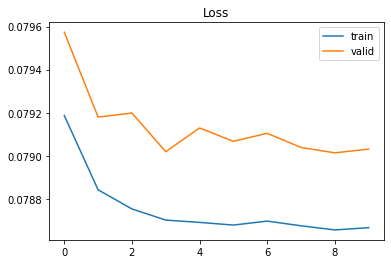

In [ ]:
plt.plot(loss_train, label="train")
plt.plot(loss_valid, label="valid")
plt.title("Loss")
plt.legend()
plt.show()

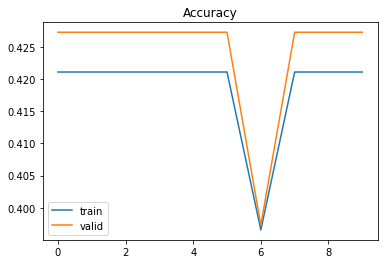

In [ ]:
plt.plot(correct_train, label="train")
plt.plot(correct_valid, label="valid")
plt.title("Accuracy")
plt.legend()
plt.show()